<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for CNN-based Drainage Feature Object Detection<br> Using Faster RCNN</h1>

<p style="text-align:center;font-size:12px;">
<strong>Department of Geography and Environmental Resources, Southern Illinois University Carbondale, IL, USA</strong><br>
<strong>Computer Science, Portland State University Portland OR, United States</strong><br>
</p>
<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Culvert Detect using Faster RCNN</h1>
<hr>

**Notebook Structure**
<br> 
 Codes
 1. CNN  Model Development
 2. FRCNN Detection **<br>
 3. Bounding Box Coordinates Processing <br>
 4. Process the DEM using Least Cost Path  <br>
 5. Hydrological Streamline detection Using UNet <br>

** Indicates Active Notebook

<h1>Read and visualize the DEM</h1>

(4800, 4800)


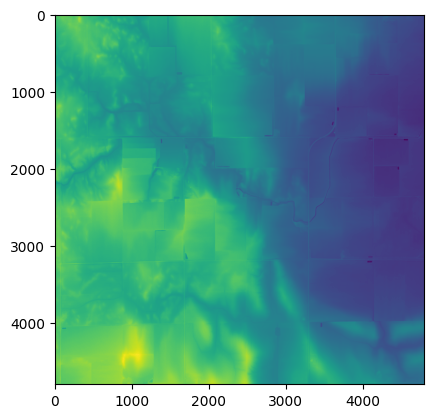

In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np

large_img = tiff.imread(r"C:\Users\mikeb\Desktop\FRCNN_predict\images\site_test.tif")
print(large_img.shape)


plt.imshow(large_img)
plt.axis()
plt.show()

<h2> Divide the DEM into patches compactible with FRCNN model</h2>

In [3]:
# Patching the images
# Visualizing the dataset
import os
import math
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image

root_directory = r"C:\Users\mikeb\Desktop\FRCNN_predict"
img_dir = os.path.join(root_directory, "images")


patch_size = 800


patches_img_dir = os.path.join(f"patches_{patch_size}", "images")
patches_img_dir = os.path.join(root_directory, patches_img_dir)
os.makedirs(patches_img_dir, exist_ok=True)


def patching(data_dir, patches_dir, patch_size):
  for filename in os.listdir(data_dir):
    if filename.endswith('.tif'):
      image = tiff.imread(os.path.join(data_dir, filename))
      print(image.shape)
#       max_height = (img.shape[0] // patch_size) * patch_size
#       max_width = (img.shape[1] // patch_size) * patch_size
#       img = img[0:max_height, 0:max_width]
      pad_height = (math.ceil(image.shape[0] / patch_size) * patch_size) - image.shape[0]
      pad_width = (math.ceil(image.shape[1] / patch_size) * patch_size) - image.shape[1]
      padded_shape = ((0, pad_height), (0, pad_width))
      global image_padded, patches
      image_padded = np.pad(image, padded_shape, mode='reflect')
      print(image_padded.shape)
      print(f"Patchifying {filename}...")
     
      patches = patchify(image_padded, (patch_size, patch_size), step = patch_size)  # non-overlapping
      print("Patches shape:", patches.shape)
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          single_patch = patches[i, j,:, :] 
#           tiff.imwrite(os.path.join(patches_dir, filename.replace(".tif", f"_patch_{i}_{j}.tif")), single_patch)
#         print(single_patch.shape)
print()
print("Dividing images into patches...")
patching(img_dir, patches_img_dir, patch_size)
print("Dividing images into patches completed successfully!")




Dividing images into patches...
(4800, 4800)
(4800, 4800)
Patchifying site_test.tif...
Patches shape: (6, 6, 800, 800)
Dividing images into patches completed successfully!


<h2> Preprocess the DEM</h2>

In [1]:
#Image Preprocessing

import os

import numpy as np
import os
import tifffile as tiff
from PIL import Image
import imageio.v2 as imageio
from tqdm import tqdm
import cv2

def normalize_images():
    PATH = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\images"
    OUT_PATH = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm"
    FILE_TYPE = '.tif'

    if not os.path.exists(OUT_PATH):
        os.makedirs(OUT_PATH)


    def apply_sobel(image,RGB=False):
        #Apply sobel filter to refine edges
        if(RGB == False):
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)

        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        return grad

    def normalize_image(img_path,out_path):

        image = tiff.imread(img_path)      
#         array = np.array(image)
#         normalized = (array.astype(np.uint16) - array.min()) * 255.0 / (array.max() - array.min())

#         image = np.array(Image.fromarray(normalized.astype(np.uint8)))

        # Calculate the histogram
        hist, bins = np.histogram(image.flatten(), bins=256, range=(image.min(), image.max()))

        # Calculate the Cumulative Distribution Function (CDF)
        cdf = hist.cumsum()

        # Normalize the CDF to have values between 0 and 255
        cdf_normalized = cdf * 255 / cdf[-1]

        # Use the CDF values to map the pixel values
        equ_image = np.interp(image.flatten(), bins[:-1], cdf_normalized)

        # Reshape the image back to its original shape
        equalized_image = equ_image.reshape(image.shape)

        image = equalized_image.astype(np.uint8)

        # convert back to PIL for saving
        image = Image.fromarray(image)
        image.save(out_path, "TIFF")
        return image


    file_list = os.listdir(PATH)
#     print(file_list)

    for filename in tqdm(file_list):
        if filename.endswith(FILE_TYPE):
            # Normalise to range 0..255
            norm = normalize_image(PATH+'/'+filename,OUT_PATH+'/'+filename)

#             print(converted_image.save(OUT_PATH+filename))


if __name__ == '__main__':
    normalize_images()

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 41.70it/s]


<h3>Use the trained  Faster RCNN model for culvert detection</h2>
<h5>The bounding box information is saved as CSV for further processing</h5>

In [2]:
import numpy as np
import tifffile as tiff
import cv2
import torch
import glob as glob
from model import create_model
from config import NUM_EPOCHS, SAVE_MODEL_EPOCH, NUM_CLASSES, CLASSES, INFER_FALSE_LABELS,DETECTION_THRESHOLD
import os
import pandas as pd

'''
NOTE: Relative paths are used in this file. These paths are relative to the root directory. If you intend on running
        This code from this file specifically, you must change them to go back a directory 
        (ie. ../outputs/model rather than ./outputs/model)
         '''

def inference():
    #compute the latest saved model based on the number of epochs and saving interval
    #np.floor((NUM_EPOCHS/SAVE_MODEL_EPOCH)*SAVE_MODEL_EPOCH)
    # set the computation device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # load the model and the trained weights
    model = create_model(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(
        './outputs/model'+str(NUM_EPOCHS)+'.pth', map_location=device
    ))
    model.eval()


    # directory where all the images are present
    DIR_TEST = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm" #'../INFERENCE_data'
    
    OUT_DIR = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\classified_images"  #'../INFERENCE_results'
    
    test_images = glob.glob(f"{DIR_TEST}/*")
    print(f"Test instances: {len(test_images)}")

    # define the detection threshold...
    # ... any detection having score below this will be discarded
    detection_threshold = DETECTION_THRESHOLD

    # create datatable to store output results
    col_names = ['file_name', 'labels','centroids','x1','x2','y1','y2']
    validation_results = pd.DataFrame(columns=col_names)

    for i in range(len(test_images)):
        # get the image file name for saving output later on
        image_name = test_images[i].split('/')[-1].split('.')[0]

#         #create new dataframe row
        validation_results.loc[validation_results.shape[0]] = [None,None,None,None,None,None,None]
#         #Store current image name
        validation_results['file_name'][i] = image_name
        print("LOADING:", test_images[i])
        image = cv2.imread(test_images[i])
        orig_image = image.copy()
        # BGR to RGB
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # make the pixel range between 0 and 1
        image /= 255.0
        # bring color channels to front
        image = np.transpose(image, (2, 0, 1)).astype(float)
        # convert to tensor
        image = torch.tensor(image, dtype=torch.float).cuda()
        # add batch dimension
        image = torch.unsqueeze(image, 0)
        with torch.no_grad():
            outputs = model(image)

        # load all detection to CPU for further operations
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        outputs = outputs[0]

#         print(outputs)
#         break


        #holds on to all info for all boxes in an image
        x1_list = []
        x2_list = []
        y1_list = []
        y2_list = []
        centroids_list = []
        labels_list = []
        # carry further only if there are detected boxes
        if len(outputs['boxes']) != 0:
            boxes = outputs['boxes'].data.numpy()
            scores = outputs['scores'].data.numpy()
            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()
            # get all the predicited class names
            pred_classes = [CLASSES[i] for i in outputs['labels'].cpu().numpy().astype(int)]

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                print(pred_classes[j])
                if(pred_classes[j] == 'False' and INFER_FALSE_LABELS == False):
                    print("Skipping False Label!")
                    continue
                cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 16)
                cv2.putText(orig_image, pred_classes[j],
                            (int(box[0]), int(box[1] - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255),
                            2, lineType=cv2.LINE_AA)
                x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
                x1_list.append(x1)
                y1_list.append(y1)
                x2_list.append(x2)
                y2_list.append(y2)
                labels_list.append(pred_classes[j])
                #centroid of a box should be the average of its 2 corners (an x,y tuple)
                centroids_list.append( ((x1+x2)/2, (y1+y2)/2) )

            cv2.imshow('Prediction', orig_image)
            cv2.waitKey(1)
            print(os.path.join(os.getcwd(), str(os.path.basename(OUT_DIR)) , os.path.split(image_name)[1]+'.tif'))
            print('Save complete: ',tiff.imwrite(os.path.join(os.getcwd(), OUT_DIR.lstrip('./') , os.path.split(image_name)[1]+'.tif'), orig_image, ))
    
        validation_results['x1'][i] = x1_list
        validation_results['y1'][i] = y1_list
        validation_results['x2'][i] = x2_list
        validation_results['y2'][i] = y2_list
        validation_results['centroids'][i] = centroids_list
        validation_results['labels'][i] = labels_list

        print(f"Image {i + 1} done...")
        print('-' * 50)


    if not os.path.exists(OUT_DIR):
        os.makedirs(OUT_DIR)
    validation_results.to_csv(r'C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\validation_results2.csv')
    print('TEST PREDICTIONS COMPLETE')
    cv2.destroyAllWindows()

if __name__ == '__main__':    
    inference()

C:\Users\mikeb\Projects\Pytorch\Pytorch\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test instances: 36
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_0_0.tif
True
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_0_0.tif
Save complete:  None
Image 1 done...
--------------------------------------------------
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_0_1.tif
True
True
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_0_1.tif
Save complete:  None
Image 2 done...
--------------------------------------------------
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_0_2.tif
True
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_0_2.tif
Save complete:  None
Image 3 done...
--------------------------------------------------
L

True
True
True
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_4_2.tif
Save complete:  None
Image 27 done...
--------------------------------------------------
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_4_3.tif
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_4_3.tif
Save complete:  None
Image 28 done...
--------------------------------------------------
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_4_4.tif
C:\Users\mikeb\Projects\Pytorch\Pytorch\env\faster_rcnn_test-main_orig\faster_rcnn_test-main\classified_images\site_test_patch_4_4.tif
Save complete:  None
Image 29 done...
--------------------------------------------------
LOADING: C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\Sample800_norm\site_test_patch_4_5.tif
C:\Users\mikeb\Project

<h2>Reconstruct the patchifed DEM and visualize</h2>

(36, 800, 800)
(6, 6, 800, 800)
(4800, 4800)


(-0.5, 4799.5, 4799.5, -0.5)

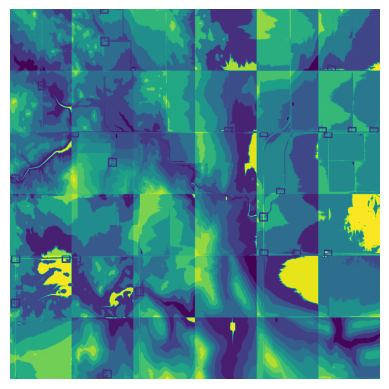

In [4]:
import numpy as np
import os
from PIL import Image
from patchify import unpatchify

img_dir = r"C:\Users\mikeb\Desktop\FRCNN_predict\patches_800\classified_images"

# Get a list of the patchified image filenames
patchified_images_filenames = os.listdir(img_dir)

# Load the patchified images and convert them to grayscale
patchified_images = []
for filename in patchified_images_filenames:
    image = Image.open(os.path.join(img_dir, filename))
    gray_image = image.convert('L')  # Convert RGB image to grayscale
    patchified_images.append(np.array(gray_image))

patchified_images = np.array(patchified_images)
print(patchified_images.shape)  # (25, 800, 800)

patchified_images = np.reshape(patchified_images, [patches.shape[0], patches.shape[1], 
                                            patches.shape[2], patches.shape[3]])
print(patchified_images.shape)


unpatched_prediction = unpatchify(patchified_images, (image_padded.shape[0],image_padded.shape[0]))

# unpad
comp_img = unpatched_prediction[:large_img.shape[0], :large_img.shape[1]]
print(comp_img.shape)
plt.imshow(unpatched_prediction)
plt.axis('off')